### Librerias necesarias

In [30]:
import pandas as pd
import numpy as np
import sqlite3 as sql
import matplotlib.pyplot as plt
import plotly_express as px
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import seaborn as sns
import datetime
from lightgbm import LGBMRegressor
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
from sklearn.metrics import r2_score

#### extraccion de la data

In [31]:
conn = sql.connect('../Data/db/btc.db')
cursor = conn.cursor()
df_1d = pd.read_sql_query("SELECT * FROM btc_1d", conn)
fecha = df_1d['date'][-1:].values[0]
ultima_fecha = pd.to_datetime(fecha)
# Número de días que quieres generar (ajusta este valor según tu necesidad)
num_dias = len(df_1d)
# Crear una lista de fechas decrementando un día en cada iteración
fechas = pd.date_range(end=ultima_fecha, periods=num_dias)

df_1d['date'] = fechas
df_1d.index = fechas

last_date = df_1d['date'][-1:].values[0]
first_date = df_1d['date'][:2].values[0]
data_1d = df_1d.loc[first_date:last_date]
inicio_train = first_date
fin_train = last_date - pd.DateOffset(days=365)
fin_validacion = last_date - pd.DateOffset(days=1)

In [32]:
from funciones import reordenar_fechas
from funciones import split_data

#### Reordenamiento de las fechas para que nuestro modelo pueda entrenarse correctamente

In [33]:
lags=[1,30,90,180]
forecaster = ForecasterAutoreg(regressor=LGBMRegressor(random_state=42, verbose=-1), lags=lags)
df_1d.fillna(0,inplace=True)
df_1d = reordenar_fechas(data=df_1d,temporalidad='1D')

#### Creacion y entrenamiento del modelo

In [34]:
df_1d['date'] = pd.to_datetime(df_1d['date'])
last_date = df_1d['date'][-1:].values[0]
first_date = df_1d['date'][:1].values[0]
inicio_train = first_date
#fin_train = last_date - pd.DateOffset(days=30)
fin_train = split_data(data=df_1d,temporalidad='1D')
inicio_train = pd.to_datetime(inicio_train)
formatted_date_inicio = inicio_train.strftime('%Y-%m-%d %H:%M:%S')
fin_train = pd.to_datetime(fin_train)
metrica, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = df_1d.loc[formatted_date_inicio:, 'close'],
    initial_train_size = len(df_1d.loc[inicio_train:fin_train]),
    #fixed_train_size   = True,
    steps              = 1,
    #refit              = True,
    metric             = 'mean_absolute_percentage_error',
    verbose            = False,
    #show_progress      = True
    )
forecaster.fit(y=df_1d['close'])
steps=5
pred_ultimo_valor = forecaster.predict(steps=steps)
pred_ultimo_valor = pd.DataFrame(pred_ultimo_valor)
predic = pd.concat(objs=[pd.Series(predicciones),pred_ultimo_valor], axis=0)
predic.reset_index(inplace=True,drop=True)
predic.columns = ['pred']
temporalidad = '1d'
largo_predictions = len(predic) -5
if (temporalidad in ['4h','4H']):
    predic['date'] = pd.date_range(start=df_1d['date'].values[-largo_predictions], periods=len(predic),freq='4H')
elif (temporalidad in ['1h','1H']):
    predic['date'] = pd.date_range(start=df_1d['date'].values[-largo_predictions], periods=len(predic),freq='1H')
elif (temporalidad in ['5m','5M']):
    predic['date'] = pd.date_range(start=df_1d['date'].values[-largo_predictions], periods=len(predic),freq='5min')
elif (temporalidad in ['1d','1D']):
    predic['date'] = pd.date_range(start=df_1d['date'].values[-largo_predictions], periods=len(predic),freq='1D')

#### Metrica y visualizacion de predicciones

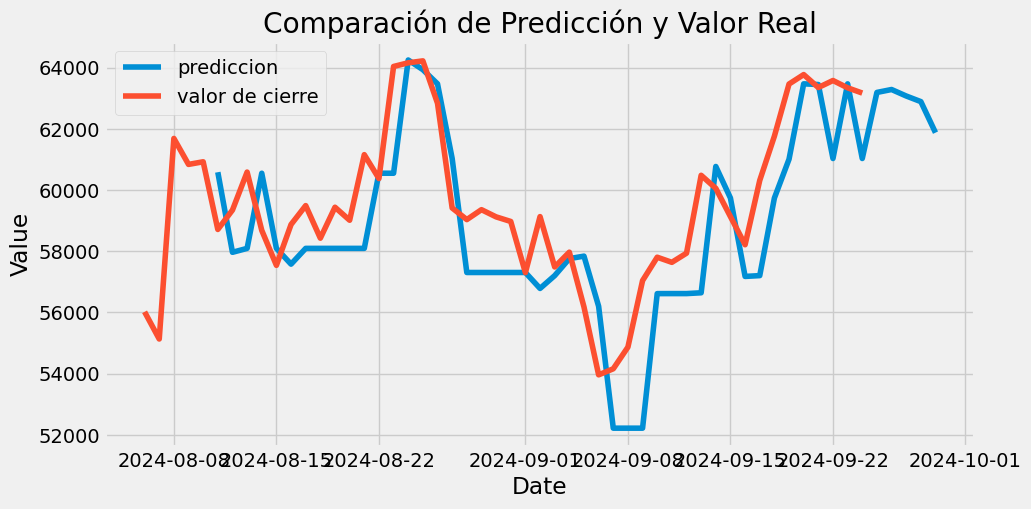

metrica 1d: [0.03921431]


In [35]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(predic['date'][-50:], predic['pred'][-50:], label='prediccion')
ax.plot(df_1d['date'][-50:], df_1d['close'][-50:], label='valor de cierre')
# Añadir etiquetas, título y leyenda
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Comparación de Predicción y Valor Real')
ax.legend()
plt.show()
print("metrica 1d:",metrica)

In [36]:
conn = sql.connect('../Data/db/btc.db')
cursor = conn.cursor()
df_4h = pd.read_sql_query("SELECT * FROM btc_4h", conn)
fecha = df_4h['date'][-1:].values[0]
ultima_fecha = pd.to_datetime(fecha)
# Número de días que quieres generar (ajusta este valor según tu necesidad)
num_dias = len(df_4h)
# Crear una lista de fechas decrementando un día en cada iteración
fechas = pd.date_range(end=ultima_fecha, periods=num_dias)

df_4h['date'] = fechas
df_4h.index = fechas

last_date = df_4h['date'][-1:].values[0]
first_date = df_4h['date'][:2].values[0]
data_1d = df_4h.loc[first_date:last_date]
inicio_train = first_date
fin_train = last_date - pd.DateOffset(days=365)
fin_validacion = last_date - pd.DateOffset(days=1)
lags=[1,30,90,180]
forecaster = ForecasterAutoreg(regressor=LGBMRegressor(random_state=42, verbose=-1), lags=lags)
df_4h.fillna(0,inplace=True)
df_4h = reordenar_fechas(data=df_4h,temporalidad='4h')
df_4h['date'] = pd.to_datetime(df_4h['date'])
last_date = df_4h['date'][-1:].values[0]
first_date = df_4h['date'][:1].values[0]
inicio_train = first_date
#fin_train = last_date - pd.DateOffset(days=30)
fin_train = split_data(data=df_4h,temporalidad='4h')
inicio_train = pd.to_datetime(inicio_train)
formatted_date_inicio = inicio_train.strftime('%Y-%m-%d %H:%M:%S')
fin_train = pd.to_datetime(fin_train)
metrica, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = df_4h.loc[formatted_date_inicio:, 'close'],
    initial_train_size = len(df_4h.loc[inicio_train:fin_train]),
    #fixed_train_size   = True,
    steps              = 1,
    #refit              = True,
    metric             = 'mean_absolute_percentage_error',
    verbose            = False,
    #show_progress      = True
    )
forecaster.fit(y=df_4h['close'])
steps=5
pred_ultimo_valor = forecaster.predict(steps=steps)
pred_ultimo_valor = pd.DataFrame(pred_ultimo_valor)
predic = pd.concat(objs=[pd.Series(predicciones),pred_ultimo_valor], axis=0)
predic.reset_index(inplace=True,drop=True)
predic.columns = ['pred']
temporalidad = '4h'
largo_predictions = len(predic) -5
if (temporalidad in ['4h','4H']):
    predic['date'] = pd.date_range(start=df_4h['date'].values[-largo_predictions], periods=len(predic),freq='4H')
elif (temporalidad in ['1h','1H']):
    predic['date'] = pd.date_range(start=df_4h['date'].values[-largo_predictions], periods=len(predic),freq='1H')
elif (temporalidad in ['5m','5M']):
    predic['date'] = pd.date_range(start=df_4h['date'].values[-largo_predictions], periods=len(predic),freq='5min')
elif (temporalidad in ['1d','1D']):
    predic['date'] = pd.date_range(start=df_4h['date'].values[-largo_predictions], periods=len(predic),freq='1D')

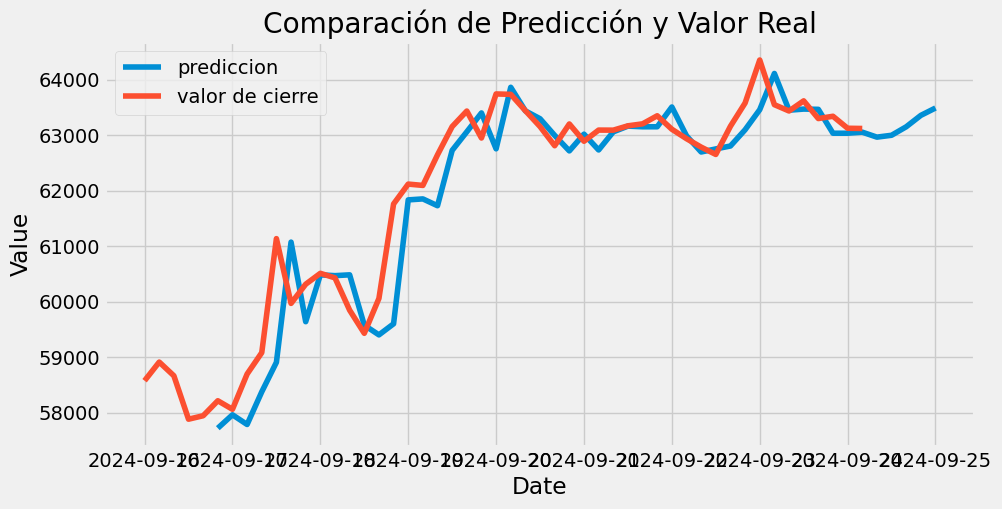

metrica 4h: [0.00785382]


In [37]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(predic['date'][-50:], predic['pred'][-50:], label='prediccion')
ax.plot(df_4h['date'][-50:], df_4h['close'][-50:], label='valor de cierre')
# Añadir etiquetas, título y leyenda
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Comparación de Predicción y Valor Real')
ax.legend()
plt.show()
print("metrica 4h:",metrica)